# Bookshelf optimization_2

In [28]:
# 色々インポート
from load_data import load_book_data
from utils import calc_max_books_per_shelf, rename_df_book, binary_expr
from amplify import BinaryPoly, gen_symbols, Solver
from amplify.client import FixstarsClient
import numpy as np
import math
# Client の設定
PROXY = 'proxy'
TOKEN = 'token'
client = FixstarsClient(proxy=PROXY)
client.token = TOKEN

In [29]:
# 本の数
n_books      = 500
# 棚の段数
n_shelves    = 6
# 棚の高さ
shelf_height = 1050
# 棚の幅
shelf_width  = 500
# 棚の高さの設定単位（50mm刻みで高さを変えられるものとする）
shelf_h_step = 50

In [30]:
# データの読み込み
df_book = load_book_data(n_books, refresh=False)
df_book = rename_df_book(df_book)
df_book['width'] = df_book['width'].astype(int)
df_book['height'] = df_book['height'].astype(int)
df_book.head(5)

,title,series,genre,width,height,author,freq
0,0_0,0,新書（ノベルス）,11,173,加藤朝陽,8.0
1,1_0,1,新書（ノベルス）,11,173,田中湊斗,3.0
2,2_0,2,文庫（文芸書）,13,148,石井陽斗,1.0
3,3_0,3,新書（文芸書）,11,173,高橋陽葵,3.0
4,3_1,3,新書（文芸書）,11,173,高橋陽葵,3.0


In [31]:
#df_book_series = df_book.groupby(['series', 'genre', 'height', 'author']).agg({'width':sum, 'freq':'mean'}).reset_index()
#n_books = df_book_series.shape[0]
df_book_series = df_book.copy()

In [32]:
# 後で扱いやすいようにリスト化
book_width  = list(df_book_series.width)
book_height = list(df_book_series.height)
book_genre  = list(df_book_series.genre)
book_freq   = list(df_book_series.freq)

In [33]:
# 各段の空きスペースの許容量を定義
## ここでは、棚の幅の 10% か 最も分厚い本の厚さ のうち大きい方とする。
p_space_width = 0.50
max_space_width = int(max(shelf_width * p_space_width, df_book_series.width.max()))
print(f'maximum space width: {max_space_width}')

maximum space width: 250


In [34]:
# 棚の高さの合計の最大値
## 問題設定上、棚の高さは 5cm 刻みになるため、本の高さや棚の高さは 5cm で割った値で考えればよい。
total_shelf_height = shelf_height // shelf_h_step
print(f'total shelf height: {total_shelf_height}')

total shelf height: 21


In [35]:
# 各棚の高さの範囲の計算
min_book_height = math.ceil(df_book_series.height.min() / shelf_h_step) 
max_book_height = math.ceil(df_book_series.height.max() / shelf_h_step)
# 各棚の高さは、少なくとも 一番小さい本の高さ以上である必要がある。
min_shelf_height = min_book_height
# N 段のうち N-1 段が最も小さい高さとしたときに、残りの1段の高さが Max となる。
max_shelf_height = int(shelf_height/shelf_h_step - min_shelf_height * (n_shelves - 1))
max_shelf_height = min(max_shelf_height, max_book_height)
print(f'shelf height range: {min_shelf_height} - {max_shelf_height}')

shelf height range: 3 - 4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff476af3ac0>,
      dtype=object)

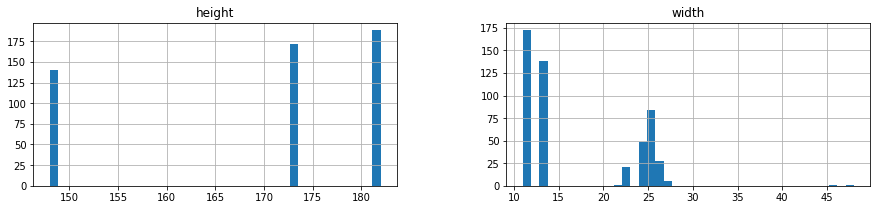

In [36]:
# 本の高さ、幅の分布
df_book_series[['height', 'width']].hist(bins=40, figsize=(15, 3))

### 定式化の方針
- 1度の最適化で本をどの段に配置するか、各棚板の高さまで決める。

### 変数定義
- すべてバイナリ変数（0/1）とする。


- $x_{b, s}$ は 本の配置を表す。
  - $x_{b, s} = 1$ のとき、本 $b$ を 上から $s$ 段目に配置するという意味とする。


- $y_{s, i}$ は $s$ 段目 の空きスペースを表すための補助的な変数。


- $z_{s, i}$ は $s$ 段目 の高さを表すための変数。
  - $\text{min_shelf_height} + \sum_{i} 2^i z_{s, i}$ が各棚の高さを表す。


- $zz_{s, i}$ は $s$ 段目に格納された本 と その上の棚板の間の空きスペースを表すための補助的な変数。


- $w_{s, i}$ は 3次式の次数を下げるための変数。

In [37]:
# 本の位置を表す変数
x_shape = (n_books, n_shelves)
print(f'x_shape: {x_shape}')

x_shape: (500, 6)


In [38]:
# 横方向の空きスペースを表す変数
y_coef_list = binary_expr(max_space_width)#, max_coef=16)
y_shape = (n_shelves, len(y_coef_list))
print(f'max_space_width = {max_space_width}, {y_coef_list}')
print(f'x_shape: {y_shape}')

max_space_width = 250, [1, 2, 4, 8, 16, 32, 64, 123]
x_shape: (6, 8)


In [39]:
# 本棚の高さを表す変数
z_coef_list = binary_expr(max_shelf_height - min_shelf_height)
z_shape = (n_shelves, len(z_coef_list))
print(f'z_shape: {z_shape}')

z_shape: (6, 1)


In [40]:
# 本と棚板の間の縦方向の空きスペースを変数
zz_shape = (n_shelves, len(z_coef_list))
print(f'zz_shape: {zz_shape}')

zz_shape: (6, 1)


In [41]:
# 3次項の次数下げ用
w_shape = (n_shelves, 1)
print(f'w_shape: {w_shape}')

w_shape: (6, 1)


In [42]:
def calc_n_vars(shape):
    n = 1
    for s in shape:
        n *= s
    return n

In [43]:
# 変数の数の計算
n_x  = calc_n_vars(x_shape)
n_y  = calc_n_vars(y_shape)
n_z  = calc_n_vars(z_shape)
n_zz = calc_n_vars(zz_shape)
n_w  = calc_n_vars(w_shape)
print(f'x : {n_x}')
print(f'y : {n_y}')
print(f'z : {n_z}')
print(f'zz: {n_zz}')
print(f'w : {n_w}')

x : 3000
y : 48
z : 6
zz: 6
w : 6


In [44]:
# スピンの作成
## 後の定式化のしやすさのために、numpy の配列に変換しておく。
s = gen_symbols(BinaryPoly, n_x + n_y + n_z + n_zz + n_w)
x = np.array(s[:n_x]).reshape(x_shape)
y = np.array(s[n_x:n_x+n_y]).reshape(y_shape)
z = np.array(s[n_x+n_y:n_x+n_y+n_z]).reshape(z_shape)
zz = np.array(s[n_x+n_y+n_z:n_x+n_y+n_z+n_zz]).reshape(zz_shape)
w = np.array(s[n_x+n_y+n_z+n_zz:]).reshape(w_shape)

### H1. 本はどこか1か所に配置されるか、どこにも配置されない。
$$H_1 = \sum_{b \in Books} \bigl\{ \bigl(\sum_{s \in Shelves} x_{b, s} - 0.5\bigl)^2 - 0.25 \bigl\}$$

In [45]:
from amplify.constraint import less_equal
# 本は必ず1か所
H1 = 0
for b in range(n_books):
    H1 += (x[b, :].sum() - 0.5) ** 2 - 0.25
#    H1 += less_equal(x[b, :, :].sum(), 1)

### H2. 棚の幅以上の本が収納されない。
- $\displaystyle H_2 = \sum_s \bigl(\text{shelf_width} - \text{total_book_width}_s - \sum_i y_{s, i} \times 2^{i} \bigl)^2$
  - $\displaystyle \text{total_book_width}_s = \sum_b \sum_s width_b x_{b, s}$

  - $y_{s, i}$ は 横方向 の空きスペースを表すための変数

  - $\text{shelf_width}$ は棚の幅

  - $width_b$ は 本 $b$ の幅

In [46]:
H2 = 0
for s in range(n_shelves):
    total_book_width = sum(x[b, s] * book_width[b] for b in range(n_books))
    slack = sum(c * y[s, i]  for i, c in enumerate(y_coef_list))
    H2 += (shelf_width - total_book_width - slack) ** 2
#    H3 += less_equal(total_book_width, shelf_width)

### H3. 各段の高さの合計は棚の高さに一致する。
- $z_{s, i}$ は $\displaystyle \sum_{i} z_{s, i}$ が 段 $s$ の高さを表す変数
- $\displaystyle H_3 = \bigl\{\sum_s \bigl(\sum_i z_{s, i} \times 2^{i} + \text{min_shelf_height}\bigl) - \text{total_shelf_height}\bigl\}^2$

- 棚の高さは $0 ～ 12$ 段階で表すこととする。

In [47]:
from amplify.constraint import equal_to
from amplify import BinaryQuadraticModel
# 本棚の高さ制約
zsum = 0
print(total_shelf_height)
for s in range(n_shelves):
    zsum += min_shelf_height + sum(c * z[s, i] for i, c in enumerate(z_coef_list))
H3 = (total_shelf_height - zsum) ** 2
#H4 = equal_to(zsum, total_shelf_height)

21


### H4. 各段に格納される本は、それぞれの段の高さを超えない。
- $zz_{s, i}$ は、$\displaystyle \sum_i zz_{s, i}$ が 各棚の各本の上の空きスペースのサイズを表す変数とする。
- 「本の高さ + $\displaystyle \sum_i zz_{s, i}$」 が「 棚の高さ $\text{shelf_height}$」と一致するように定式化


- $\displaystyle H_4 = \sum_b \sum_s x_{b,s} \bigl\{\text{shelf_height} - \text{book_height}(b) - \sum_i  zz_{s, i} \times 2^{i}\bigl\}^2$  
  
  $\text{shelf_height} = (\sum_i z_{s, i} \times 2^{i} + \text{min_shelf_height}\bigl)$


- <span style='color:red'>※注意</span>
  - <span style='color:red'>本制約式は 3次式になるため、実際のコードは 手作業で2次式となるようにしている。</span>
  - <span style='color:red'>格段の可変幅は 15cm ～ 20cm とする。</span>
  - <span style='color:red'>問題設定上 25cm の設定も可能ではあるが、本の最大サイズが 20cm 以下のため考えないこととする。</span>  

In [48]:
from amplify.constraint import greater_equal
# 各棚の高さ制約（3次式）
H4 = 0
H_sup = 0
for b in range(n_books):
    for s in range(n_shelves):
        # 棚の高さ
        sh = min_shelf_height + sum(c * z[s, i] for i, c in enumerate(z_coef_list))
        # 本の高さ
        bh = math.ceil(book_height[b] / shelf_h_step)
        # 本の高さが 3 の場合、zz[s, 0] を空きスペースとして追加する。
        if (max_shelf_height - bh == 1):
            diff = z[s, 0] + zz[s, 0] - 2 * w[s, 0]
            # z[s, 0] * zz[s, 0] == w[s, 0] を満たすための制約式。
            H_sup += z[s, 0] * zz[s, 0] - 2 * z[s, 0] * w[s, 0] - 2 * zz[s, 0] * w[s, 0] + 3 * w[s, 0]
        # 本の高さが 4 の場合、空きスペースは不要。
        elif (max_shelf_height - bh == 0):
            diff = 1 - z[s, 0]

        H4 += diff * x[b, s]

### S1. 同じジャンルの本は同じ段に入れやすくする（ソフト制約）
- 同じジャンルの本が同じ段に配置された場合、負のエネルギーが発生するものとする。
- $\displaystyle S_1 = - \sum_{g \in \text{genre}} \sum_{b_1, b_2 \in books(g)} x_{b_1, s} x_{b_2, s}$ 

In [49]:
# なるべく近いジャンルをまとめたい。
from itertools import combinations

genre_list = list(df_book_series.genre.unique())
S1 = 0
cnt = 0
for g in genre_list:
    bs = [b for b in range(n_books) if (book_genre[b] == g)]
    for s in range(n_shelves):
        S1 -= sum(x[b1, s] * x[b2, s] for b1, b2 in combinations(bs, 2))
        cnt += len(list(combinations(bs, 2)))
S1 = S1 / cnt

### S2. 使用頻度の大きい本を優先的に配置する（ソフト制約）
- 使用頻度の値を -1 倍した分のエネルギーが発生するものとする。
- $\displaystyle S_2 = - \sum_{b \in \text{books}} \sum_{s \in \text{shelves}} freq(b) \times x_{b, s}$ 

In [50]:
# 規格化用の定数（ここでは 使用頻度の合計値）
total_freq = sum(book_freq)
# 定式化
S2 = - sum(book_freq[b] / total_freq * x[b, :].sum() for b in range(n_books))

In [69]:
h1 = 20
h2 = 1
h3 = 500
h4 = 75
s1 = 50
s2 = 1

In [70]:
f = h1*H1 + h2*H2 + h3*H3 +h4*(H4 + H_sup) + s1*S1 + s2*S2

### 最適化の実行

In [71]:
client.parameters.timeout = 60000  # タイムアウト1秒
client.parameters.num_unit_steps = 100
solver = Solver(client)

In [72]:
import time
print(time.time())
result = solver.solve(f)
print(time.time())

1617186948.3273642
1617187022.3625715


In [73]:
def check(result, y_coef_list, z_coef_list):
    solution = result[0]
    sample = solution.values
    print(f'Solution\'s Length = {len(sample)}')
    print(f'Solution\'s Energy = {solution.energy}')
    e1 = 0
    e2 = 0
    e4 = 0
    shelf_height_list = []
    book_list = []
    x = np.array([sample[i] for i in range(n_x)]).reshape(x_shape)
    z = np.array([sample[n_x+n_y+i] for i in range(n_z)]).reshape(z_shape)
    for s in range(n_shelves):
        print(f'## Shelf {s} #######################')
        # 本の横幅の計算
        total_book_width = 0
        total_book_width = sum(book_width[b] * x[b][s] for b in range(n_books))
        bl = [b for b in range(n_books) if x[b][s] == 1]
        book_list.append(bl)

        # 棚の縦幅の計算
        height = (min_shelf_height + sum(z[s][i] * c for i, c in enumerate(z_coef_list))) * shelf_h_step
        shelf_height_list.append(height)

        # 収納された本の情報の表示
        books = [(b, book_height[b], book_width[b]) for b in range(n_books) if x[b][s]]
        for b in books:
            print(f'book {b} {"SIZE OVER" if height < book_height[b[0]] else ""}')
            if height < book_height[b[0]]:
                e4 += math.ceil((book_height[b[0]] - height) / shelf_h_step) ** 2

        if total_book_width > shelf_width:
            e2 += 1
        
        print(f'book width   = {total_book_width} [mm]')
        print(f'shelf height = {height} [mm]')

    total_height = sum(shelf_height_list)
    print(f'Total height: {total_height}')

    # 本の重複チェック
    for b in range(n_books):
        nb = 0
        for s in range(n_shelves):
            nb += x[b][s]

        if nb > 1:
            print(f'book {b} = {nb}')
            e1 += (nb - 0.5) ** 2 -0.25
    e3 = (shelf_height / shelf_h_step - total_height / shelf_h_step) ** 2

    # 各制約式のエネルギー（係数除く）の表示
    print(f'H1 (duplicated book) = {e1 == 0}')
    print(f'H2 (shelf_width)     = {e2 == 0}')
    print(f'H3 (shelf_height)    = {e3 == 0}')
    print(f'H4 (book_height)     = {e4 == 0}')
    
    S2 = sum(book_freq[b] * x[b, :].sum() for b in range(n_books))
    print(f'Total frequency: {S2}')
    print('')
    judge = (e1 == 0) and (e2 == 0) and (e3 == 0) and (e4 == 0)
    return sample, book_list, shelf_height_list, judge

In [74]:
sample, bl, sl, judge = check(result, y_coef_list, z_coef_list)

Solution's Length = 3066
Solution's Energy = -1.200077037456822
## Shelf 0 #######################
book (22, 173, 11) 
book (23, 173, 11) 
book (57, 182, 26) 
book (71, 182, 24) 
book (79, 173, 11) 
book (80, 173, 11) 
book (85, 173, 11) 
book (124, 173, 11) 
book (143, 173, 11) 
book (144, 173, 11) 
book (158, 182, 26) 
book (197, 173, 11) 
book (199, 173, 11) 
book (200, 173, 11) 
book (201, 173, 11) 
book (208, 173, 11) 
book (223, 182, 25) 
book (242, 173, 11) 
book (268, 182, 24) 
book (293, 173, 11) 
book (294, 173, 11) 
book (298, 182, 24) 
book (355, 173, 11) 
book (357, 173, 11) 
book (358, 173, 11) 
book (363, 173, 11) 
book (407, 173, 11) 
book (408, 173, 11) 
book (411, 173, 11) 
book (418, 173, 11) 
book (421, 173, 11) 
book (431, 173, 11) 
book (432, 173, 11) 
book (454, 173, 11) 
book (466, 182, 23) 
book (488, 173, 11) 
book width   = 491 [mm]
shelf height = 200 [mm]
## Shelf 1 #######################
book (10, 148, 13) 
book (27, 148, 13) 
book (29, 148, 13) 
book (30,

### 各段の本のソート
- ここもなんらかの最適化を実施できれば良いが今回は時間切れ。。。
- 単純にジャンル順、タイトル順にソートすることとする。

In [75]:
sorted_bl = [
    list(df_book[df_book.index.isin(b)].sort_values(['genre', 'title']).index) for b in bl
]

### 結果の可視化

In [76]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def vis_shelf(shelf_board, order_list):
    color = ["r", "g", "b", "c", "m", "y", "k", "orange", "purple", "lightgreen"]
    genre = list(df_book_series.genre.unique())
    
    fig = plt.figure(figsize=(6, 10))
    ax = plt.axes()
    ax.set_xlim(0, shelf_width)
    ax.set_ylim(0, shelf_height)

    # fc = face color, ec = edge color
    y = shelf_height 
    for j, order in enumerate(order_list):
        y -= shelf_board[j]
        ax.hlines(y, 0, shelf_width, "black") 
        x = 0
        for b in order:
            r = patches.Rectangle(
                xy=(x, y),
                width=book_width[b],
                height=book_height[b], 
                ec=color[genre.index(book_genre[b])],
                fc=color[genre.index(book_genre[b])], alpha=0.3)
            ax.add_patch(r)
            x += book_width[b]
    plt.show()

result: OK


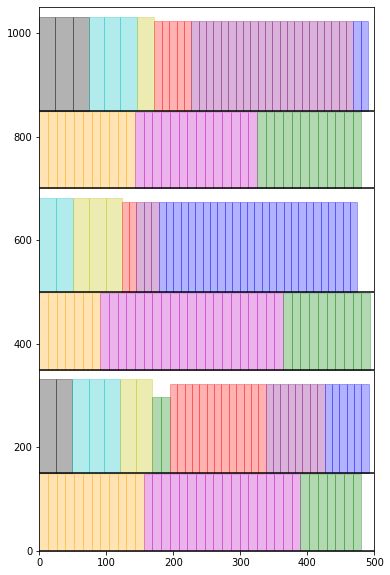

In [77]:
print(f'result: {"OK" if judge else "NG"}')
if judge:
    vis_shelf(sl, sorted_bl)